<a href="https://colab.research.google.com/github/kebabee/autoencoder-memory/blob/main/hopfield_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D

# Classic Hopfield network:

The calssic Hopfield Network is a recurrent neural network model, every neuron is connected to each other and send information in both ways.

Information processed by network is vector with the same nuber of elements as number of neurons in network. There is no commonly known input-hidden-output layers structure, the network is input and output layer by itself. The update rule of neuron is given by:

$$\xi_i^{new} = sgn[\sum_j (W_{ij} \xi_j)]$$

where $\xi_i$ is state of neuron and *W* is connections weights matrix. Rules of this matrix are:

$$W_{ij}=\frac{1}{S} \sum_{\mu=1}^S x_i^\mu x_j^\mu$$

$$W_{ij}=W_{ji}$$

$$W_{ii}=0$$

Where *x* is pattern vector to remember and *S* is number of patterns.

Whole model have some similar elements with Ising model, so classic Hopfield Network can be described by his own energy function:

$$E = -\frac{1}{2}\sum^N_{i,j} W_{ij} \xi_i \xi_j$$

In every update of neuron the energy is lowered or stays the same. The goal is convergence to energy minima, where most similar pattern is "stored".

## Hopfield Netrworwork class

In [ ]:
class hopfield_net:
    def __init__(self, num_of_neurons): # constructor
        self.num_of_neurons = num_of_neurons
        self.num_of_patterns = 0
        self.weights = np.random.uniform(-0.3,0.3,(num_of_neurons, num_of_neurons)) #weight matrix, random numbers on the beginning
        np.fill_diagonal(self.weights, 0) # w_ii = 0
        self.patterns = [] # vector with patterns

    def learn(self, patterns): # Hebb's learning
        for patt in patterns:
          self.patterns.append(patt)
        self.num_of_patterns += len(patterns)
        for i in range(self.num_of_neurons):
            for j in range(self.num_of_neurons):
                if i != j:
                    for pattern in patterns: # for every pattern
                        self.weights[i][j] += pattern[i] * pattern[j] / self.num_of_patterns
                    #self.weights[i][j] /= num_patterns # normalize by number of neurons and patterns

    def forget(self, pattern): # Hebb's forgetting
        #self.patterns.remove(pattern)
        self.num_of_patterns -= 1
        for i in range(self.num_of_neurons):
            for j in range(self.num_of_neurons):
                if i != j:
                    self.weights[i][j] -= pattern[i] * pattern[j] / self.num_of_patterns

    def test(self, data, max=10): # modyfikacja synchroniczna
    #max odpowiada za maksymalną liczbę iteracji
        for i in range(max):
            new_data = np.dot(self.weights, data) # obliczanie aktywacji każdego neuronu
            new_data = np.where(new_data >= 0, 1, -1) # aktualizacja stanu zgodnie z sgn(x)

            energy = self.calculate_energy(new_data)
            print(f'Iteration {i}, energy: {energy}')

            # jeśli stan sieci nie ulega zmianie to kończymy działanie
            if (np.array_equal(data,new_data)):
                closestPattern = min(self.patterns, key=lambda pattern: np.sum(pattern != new_data))
                error = np.sum(new_data != closestPattern)
                print(f'Completed in {i} iterations (network stable), error: {error}')
                return new_data

            data = new_data #nadpisywanie danych
        print(f'Completed in {i} iterations (iterations limit)')
        return data

    def asyn_test(self, data, max=10): # asynchronic updates of neurons
        for i in range(max):
            new_data = np.copy(data)
            indices = list(range(len(data)))  # list of neuron indexes
            random.shuffle(indices)

            for index in indices: # updates in random order
                activation = np.dot(self.weights[index], new_data)
                new_data[index] = 1 if activation >= 0 else -1

            energy = self.calculate_energy(new_data)
            print(f'Iteration {i}, energia: {energy}')

            # when network stop changing itself, the loop is over
            if np.array_equal(data, new_data):
                closest_pattern = min(self.patterns, key=lambda pattern: np.sum(pattern != new_data))
                error = np.sum(new_data != closest_pattern)
                print(f'Completed in {i} iterations (network stable), error: {error}')
                return new_data

            data = new_data  # update data

        print(f'Completed in {i} iterations (iteration limit))')
        return data

    def plot_weights(self, title): # plot weight matrix
        norm_weights = (self.weights + 1) / 2 # normalize to [0,1]
        plt.imshow(norm_weights)
        #plt.savefig(f"shit/"+title)
        plt.show()

    def plot_patterns(self, height, width, filename): # plot patterns
        for i in range(len(self.patterns)):
            pattern = self.patterns[i].reshape(height, width) # reshape to square matrix
            plt.imshow(pattern, cmap='inferno')
            name = filename+f'{i}.png'
            plt.grid(False)
            plt.axis('off')
            # plt.savefig(f"wyniki6/"+name)
            plt.show()
            plt.close()

    def calculate_energy(self, state):
        energy = -0.5*np.dot(np.dot(np.transpose(state),self.weights),state)
        return energy

    def optim_learn6(self, pattern, learning_rate):
        evol_pattern = self.asyn_test(pattern)

        self.weights += learning_rate*(np.outer(pattern, pattern) - np.outer(evol_pattern, evol_pattern))
        np.fill_diagonal(self.weights, 0)

    def reversed_optim_learn6(self, pattern, learning_rate):
        evol_pattern = self.asyn_test(pattern)

        self.weights += learning_rate*(- np.outer(pattern, pattern) + np.outer(evol_pattern, evol_pattern))
        np.fill_diagonal(self.weights, 0)

In [ ]:
def add_noise(images, noise_factor):
    noisy_images = images.copy()
    n_pixels = int(noise_factor * images.shape[1])
    for img in noisy_images:
        noise_idx = np.random.choice(images.shape[1], n_pixels, replace=False)
        for i in range(n_pixels):
            img[noise_idx[i]] = 0
    return noisy_images

def cut(data, changes=1):
    temp_data = data.copy()
    for i in range(changes):
        temp_data[i] = 0
    return temp_data

Importing MNIST:

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

selected_digits = []
for digit in range(10):
  idx = np.where(y_train == digit)[0][0]
  selected_digits.append(x_train[idx])

selected_digits = np.array(selected_digits).reshape(-1, 28, 28)
selected_digits = np.where(selected_digits <= 100, -1, 1) # rescale to {-1,1}
selected_digits = selected_digits.reshape(-1, 784) # to vector

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
rand5_digits = add_noise(selected_digits, 0.05)
rand10_digits = add_noise(selected_digits, 0.1)
rand15_digits = add_noise(selected_digits, 0.15)
rand20_digits = add_noise(selected_digits, 0.2)

Hopfield network was designed to work on bipolar values. 100 digits examples were transformed to -1 and 1 values only, some examples:

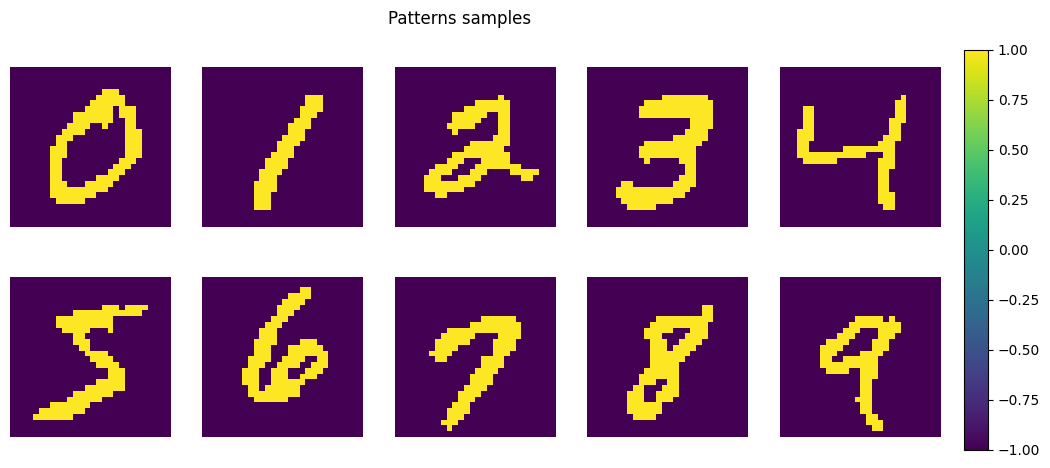

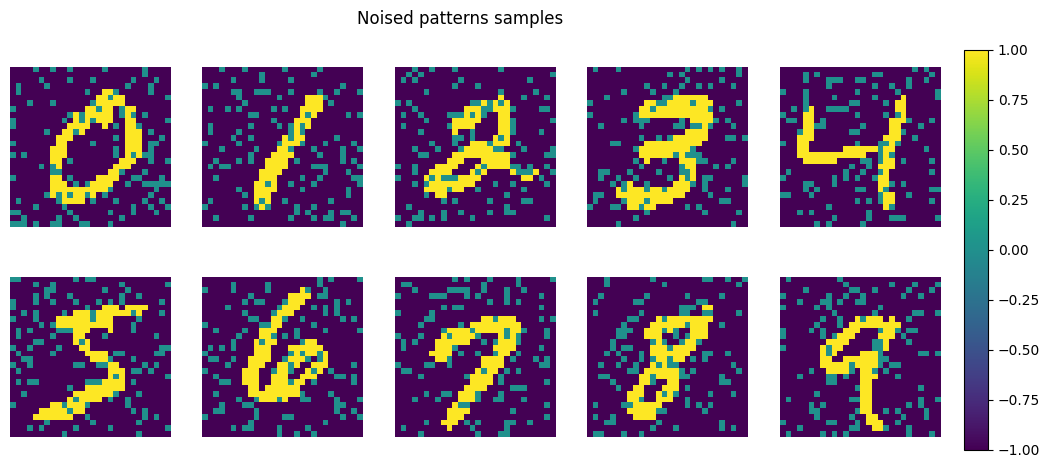

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Position for the colorbar

for i in range(10):
    row, col = i // 5, i % 5
    im = axes[row, col].imshow(selected_digits[i].reshape(28, 28))
    axes[row, col].axis('off')

fig.colorbar(im, cax=cax)
plt.suptitle("Patterns samples")
plt.show()
print()

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

for i in range(10):
    row, col = i // 5, i % 5
    im = axes[row, col].imshow(rand15_digits[i].reshape(28, 28))
    axes[row, col].axis('off')

fig.colorbar(im, cax=cax)
plt.suptitle("Noised patterns samples")
plt.show()

## Learning time

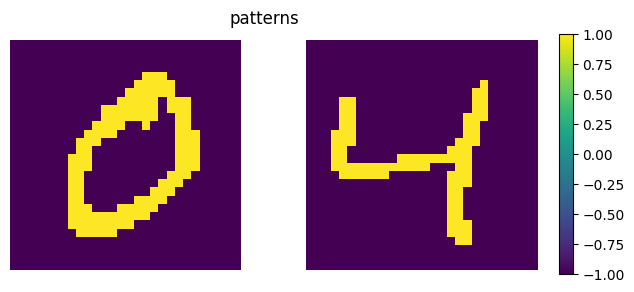

In [ ]:
network = hopfield_net(28*28)
network.learn([selected_digits[0], selected_digits[4]])
test_digits = [rand5_digits[0], rand5_digits[4], rand10_digits[0], rand10_digits[4],
               rand15_digits[0], rand15_digits[4], rand20_digits[0], rand20_digits[4]]

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

for i in range(2):
    im = axes[i].imshow(network.patterns[i].reshape(28, 28))
    axes[i].axis('off')

fig.colorbar(im, cax=cax)
plt.suptitle("patterns")
plt.show()

Learning over, test data set:

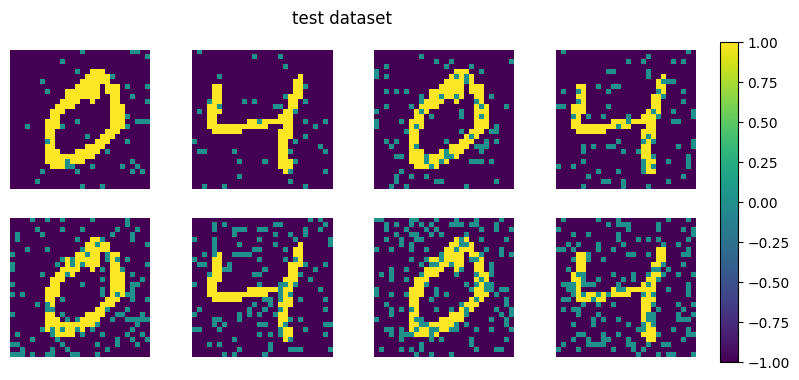

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

for i in range(8):
    row, col = i // 4, i % 4
    im = axes[row, col].imshow(test_digits[i].reshape(28, 28))
    axes[row, col].axis('off')

fig.colorbar(im, cax=cax)
plt.suptitle("test dataset")
plt.show()

Iteration 0, energia: -199918.72579760978
Iteration 1, energia: -199918.72579760978
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -200284.99628573906
Iteration 1, energia: -200284.99628573906
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -199918.72579760978
Iteration 1, energia: -199918.72579760978
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -200284.99628573906
Iteration 1, energia: -200284.99628573906
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -199918.72579760978
Iteration 1, energia: -199918.72579760978
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -200284.99628573906
Iteration 1, energia: -200284.99628573906
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -199918.72579760978
Iteration 1, energia: -199918.72579760978
Completed in 1 iterations (network stable), error: 0
Iteration 0, energia: -200284.99628573906

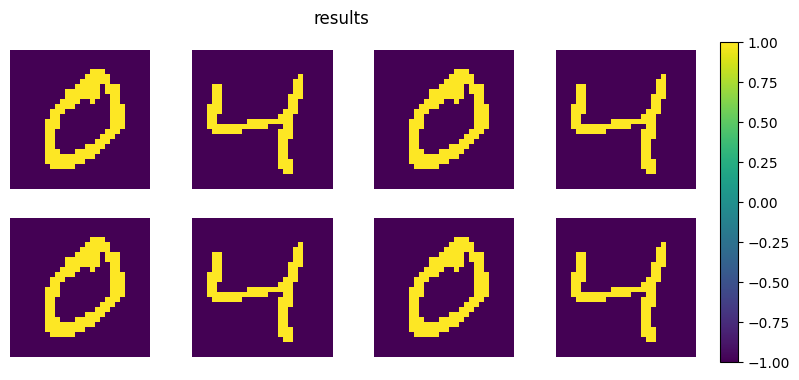

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(9, 4))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

for i in range(8):
  result = network.asyn_test(test_digits[i])
  row, col = i // 4, i % 4
  axes[row, col].imshow(result.reshape(28, 28))
  axes[row, col].axis('off')

fig.colorbar(im, cax=cax)
plt.suptitle("results")
plt.show()

Network reconstructed 2 patterns, let's check how the weghts of connections have changed.

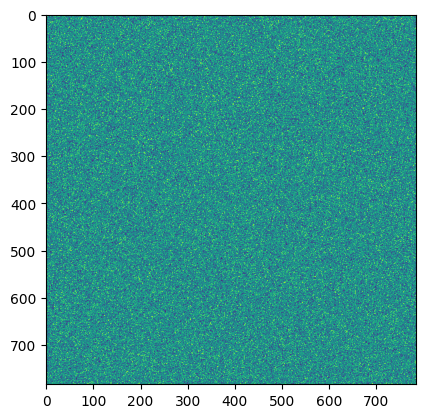

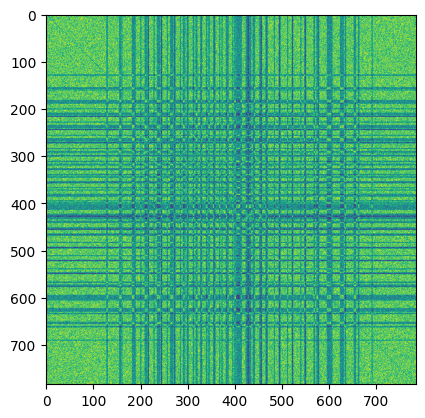

In [ ]:
network = hopfield_net(28*28)
network.plot_weights("a")
network.learn([selected_digits[0], selected_digits[4]])
network.plot_weights("a")

The weights seems to be well structured.

## Weights analysis

In detailed analysis I will examine 36-neuron network with one given pattern at the time. It may be possible to see some structures in weight matrix.

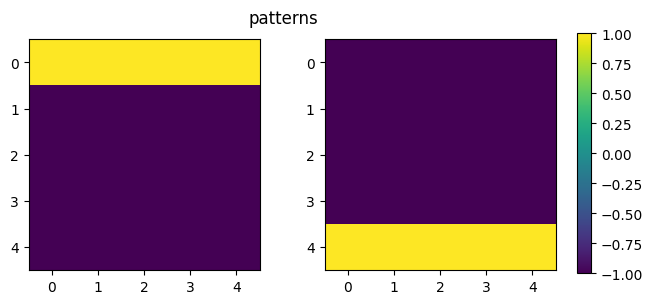

In [ ]:
pattern1 = np.array([1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
pattern2 = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1])

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(pattern1.reshape(5, 5))
im = axes[1].imshow(pattern2.reshape(5, 5))

fig.colorbar(im, cax=cax)
plt.suptitle("patterns")
plt.show()

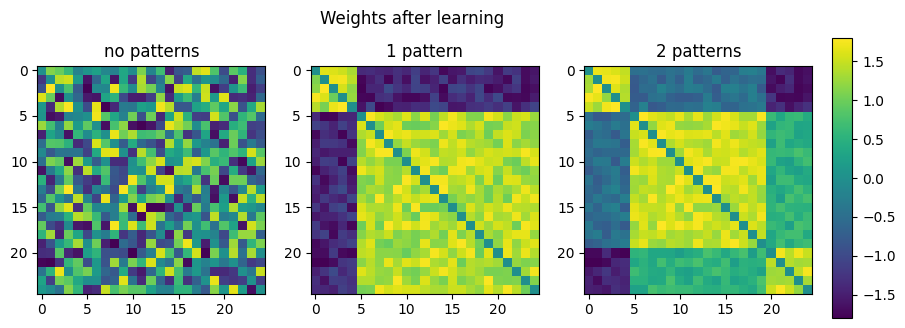

In [ ]:
network = hopfield_net(25)

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network.weights)
axes[0].set_title("no patterns")
network.learn([pattern1])
im = axes[1].imshow(network.weights)
axes[1].set_title("1 pattern")
network.learn([pattern2])
im = axes[2].imshow(network.weights)
axes[2].set_title("2 patterns")

fig.colorbar(im, cax=cax)
plt.suptitle("Weights after learning")
plt.show()

Weight matrix is structured in some way. In "1 pattern" case the connections between neurons with the same value (+1 -> +1 and -1 -> -1) is stronger (left upper smaller square and second bigger square), it is expected from the equation. What will happen after "inversed learning" on "2 patterns" weight matrix?

Iteration 0, energia: -302.7309041003589
Completed in 0 iterations (network stable), error: 0
Iteration 0, energia: -151.27602160945344
Completed in 0 iterations (network stable), error: 0


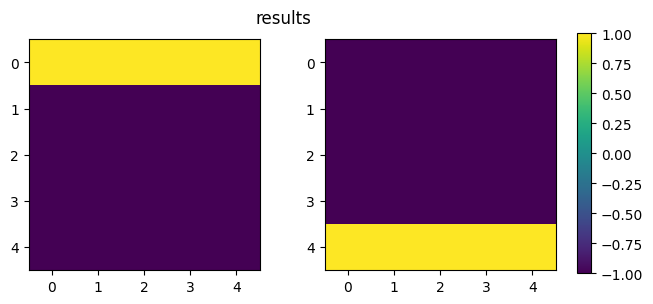

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network.asyn_test([1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]).reshape(5, 5))
im = axes[1].imshow(network.asyn_test([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1]).reshape(5, 5))

fig.colorbar(im, cax=cax)
plt.suptitle("results")
plt.show()

Network worked propertly, 2 patterns are stable.

In [ ]:
for i in range(network.num_of_neurons):
  for j in range(network.num_of_neurons):
    if i != j:
      network.weights[i][j] -= pattern2[i] * pattern2[j] / 2

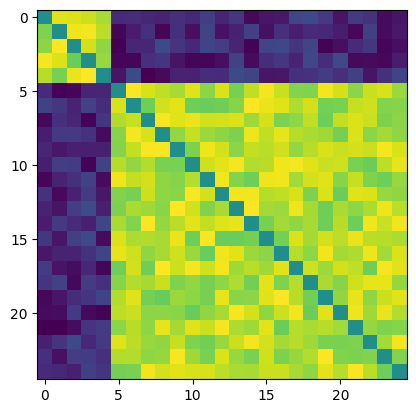

In [ ]:
plt.imshow(network.weights)
plt.show()

Iteration 0, energia: -302.7309041003589
Completed in 0 iterations (network stable), error: 0
Iteration 0, energia: -302.7309041003589
Iteration 1, energia: -302.7309041003589
Completed in 1 iterations (network stable), error: 0


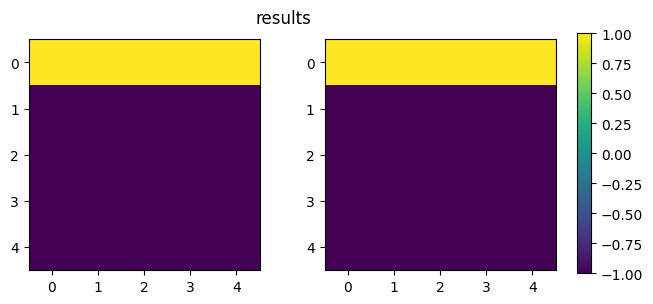

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network.asyn_test([1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]).reshape(5, 5))
im = axes[1].imshow(network.asyn_test([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1]).reshape(5, 5))

fig.colorbar(im, cax=cax)
plt.suptitle("results")
plt.show()

### Another example

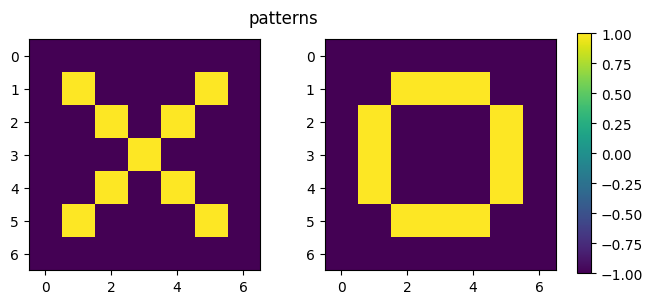

In [ ]:
p1 = np.array([-1,-1,-1,-1,-1,-1,-1,
               -1,1,-1,-1,-1,1,-1,
               -1,-1,1,-1,1,-1,-1,
               -1,-1,-1,1,-1,-1,-1,
               -1,-1,1,-1,1,-1,-1,
               -1,1,-1,-1,-1,1,-1,
               -1,-1,-1,-1,-1,-1,-1])
p2 = np.array([-1,-1,-1,-1,-1,-1,-1,
               -1,-1,1,1,1,-1,-1,
               -1,1,-1,-1,-1,1,-1,
               -1,1,-1,-1,-1,1,-1,
               -1,1,-1,-1,-1,1,-1,
               -1,-1,1,1,1,-1,-1,
               -1,-1,-1,-1,-1,-1,-1])

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(p1.reshape(7, 7))
im = axes[1].imshow(p2.reshape(7, 7))

fig.colorbar(im, cax=cax)
plt.suptitle("patterns")
plt.show()

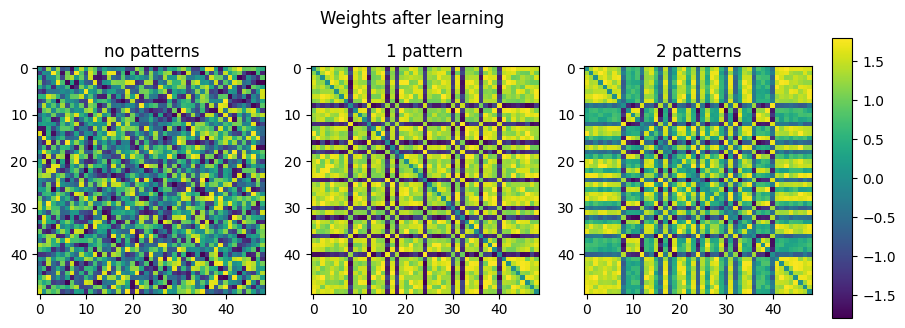

In [ ]:
network2 = hopfield_net(49)

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network2.weights)
axes[0].set_title("no patterns")
network2.learn([p1])
im = axes[1].imshow(network2.weights)
axes[1].set_title("1 pattern")
network2.learn([p2])
im = axes[2].imshow(network2.weights)
axes[2].set_title("2 patterns")

fig.colorbar(im, cax=cax)
plt.suptitle("Weights after learning")
plt.show()

Iteration 0, energia: -1176.1934822082621
Completed in 0 iterations (network stable), error: 0
Iteration 0, energia: -587.2086272171214
Completed in 0 iterations (network stable), error: 0


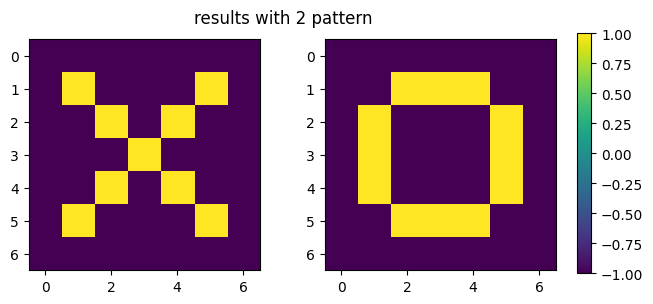

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network2.asyn_test(p1).reshape(7, 7))
im = axes[1].imshow(network2.asyn_test(p2).reshape(7, 7))

fig.colorbar(im, cax=cax)
plt.suptitle("results with 2 pattern")
plt.show()

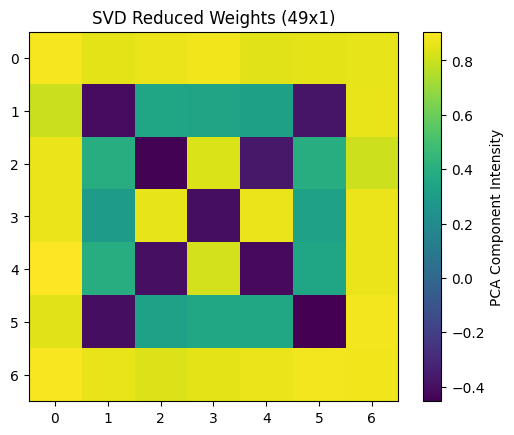

In [ ]:
reduced_vector2 = np.mean(network2.weights, axis=1)
plt.imshow(reduced_vector2.reshape(7,7))
plt.colorbar(label='PCA Component Intensity')
plt.title('SVD Reduced Weights (49x1)')
plt.show()

In [ ]:
for i in range(network2.num_of_neurons):
  for j in range(network2.num_of_neurons):
    if i != j:
      network2.weights[i][j] -= p2[i] * p2[j] / 2

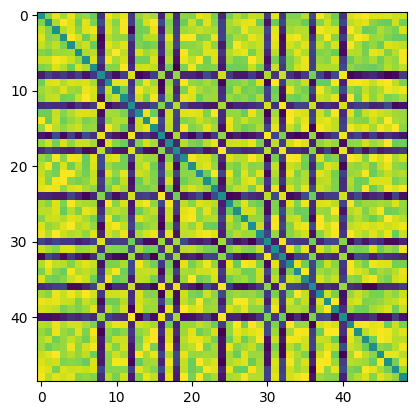

In [ ]:
plt.imshow(network2.weights)
plt.show()

Iteration 0, energia: -1176.1934822082621
Completed in 0 iterations (network stable), error: 0
Iteration 0, energia: -1176.1934822082621
Iteration 1, energia: -1176.1934822082621
Completed in 1 iterations (network stable), error: 0


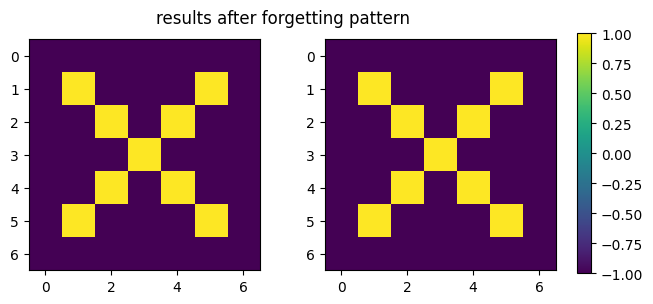

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network2.asyn_test(p1).reshape(7, 7))
im = axes[1].imshow(network2.asyn_test(p2).reshape(7, 7))

fig.colorbar(im, cax=cax)
plt.suptitle("results after forgetting pattern")
plt.show()

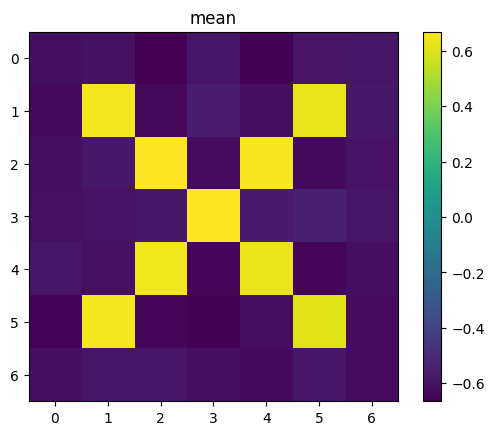

In [ ]:
reduced_vector2 = np.mean(network2.weights, axis=0)
plt.imshow(reduced_vector2.reshape(7,7))
plt.colorbar()
plt.title('mean')
plt.show()

Iteration 0, energia: -1176.1934822082621
Completed in 0 iterations (network stable), error: 0
Iteration 0, energia: -1176.1934822082621
Iteration 1, energia: -1176.1934822082621
Completed in 1 iterations (network stable), error: 0


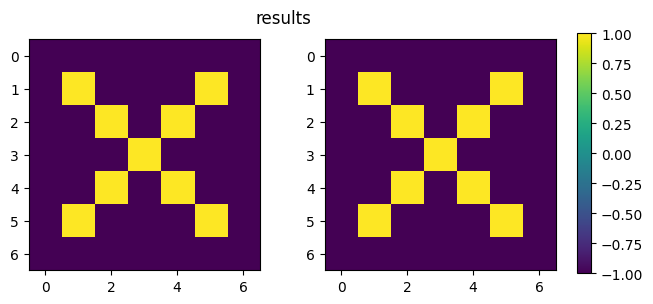

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(network2.asyn_test(p1).reshape(7, 7))
im = axes[1].imshow(network2.asyn_test(p2).reshape(7, 7))

fig.colorbar(im, cax=cax)
plt.suptitle("results")
plt.show()

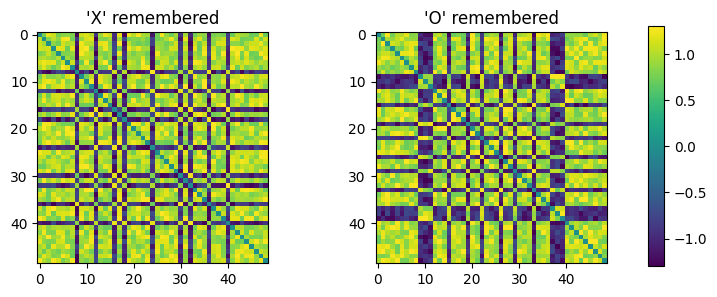

In [ ]:
netw1 = hopfield_net(49)
netw1.learn([p1])
netw2 = hopfield_net(49)
netw2.learn([p2])

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(netw1.weights)
axes[0].set_title("'X' remembered")
im = axes[1].imshow(netw2.weights)
axes[1].set_title("'O' remembered")

fig.colorbar(im, cax=cax)
plt.show()

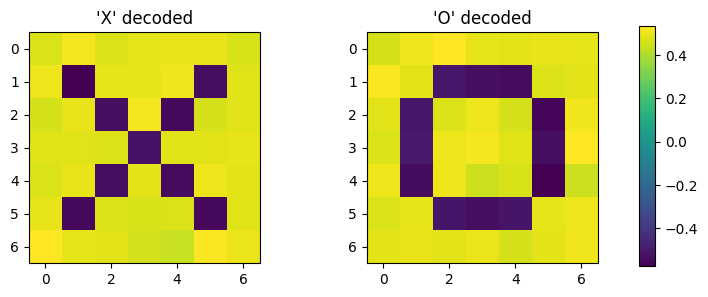

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

reduced_v1 = np.mean(netw1.weights, axis=0)
im = axes[0].imshow(reduced_v1.reshape(7,7))
axes[0].set_title("'X' decoded")

reduced_v2 = np.mean(netw2.weights, axis=0)
im = axes[1].imshow(reduced_v2.reshape(7,7))
axes[1].set_title("'O' decoded")

fig.colorbar(im, cax=cax)
plt.show()

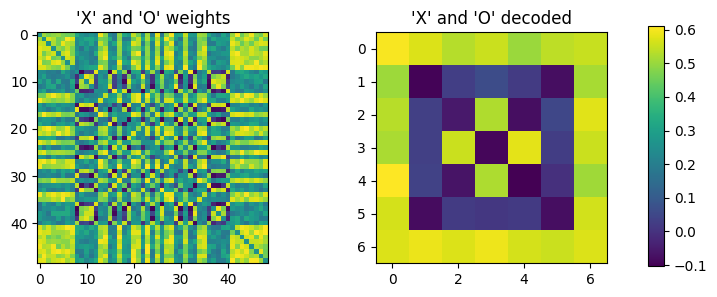

In [ ]:
netw3 = hopfield_net(49)
netw3.learn([p1, p2])

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

im = axes[0].imshow(netw3.weights)
axes[0].set_title("'X' and 'O' weights")

reduced_v3 = np.mean(netw3.weights, axis=0)
im = axes[1].imshow(reduced_v3.reshape(7,7))
axes[1].set_title("'X' and 'O' decoded")

fig.colorbar(im, cax=cax)
plt.show()

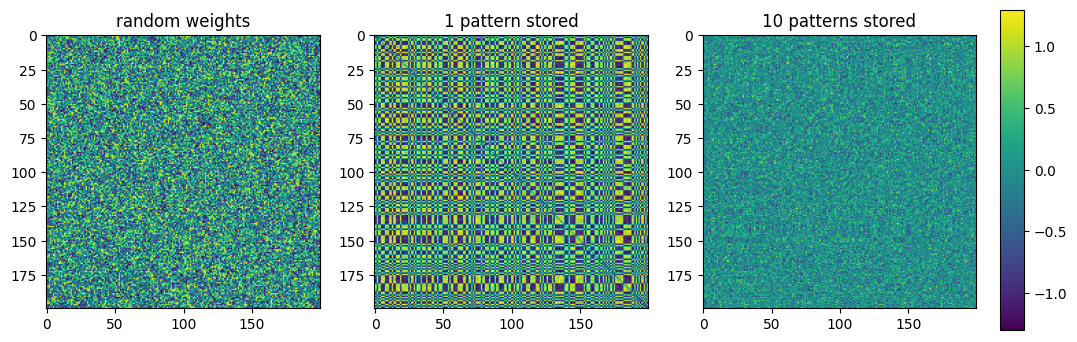

In [ ]:
random_patt1 = np.random.choice([-1, 1], size=200)
random_patt2 = np.random.choice([-1, 1], size=200)
random_patt3 = np.random.choice([-1, 1], size=200)
random_patt4 = np.random.choice([-1, 1], size=200)
random_patt5 = np.random.choice([-1, 1], size=200)
random_patt6 = np.random.choice([-1, 1], size=200)
random_patt7 = np.random.choice([-1, 1], size=200)
random_patt8 = np.random.choice([-1, 1], size=200)
random_patt9 = np.random.choice([-1, 1], size=200)
random_patt10 = np.random.choice([-1, 1], size=200)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

netw4 = hopfield_net(200)
im = axes[0].imshow(netw4.weights)
axes[0].set_title("random weights")
netw4.learn([random_patt1])
netw5 = hopfield_net(200)
netw5.learn([random_patt1, random_patt2, random_patt3, random_patt4, random_patt5, random_patt6, random_patt7, random_patt8, random_patt9, random_patt10])

im = axes[1].imshow(netw4.weights)
axes[1].set_title("1 pattern stored")
im = axes[2].imshow(netw5.weights)
axes[2].set_title("10 patterns stored")

fig.colorbar(im, cax=cax)
plt.show()